# Description
Load trained models for the extended cell organelle dataset and plot accuracy vs compression ratio for the different models.

# Load Libraries

In [2]:
from __future__ import print_function
import os, sys
import math
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.swa_utils import AveragedModel, SWALR
from torch.optim.lr_scheduler import CosineAnnealingLR
import optuna
import ray

import wandb
from torchvision import datasets, transforms
import torchvision

In [3]:
""" Training and hyperparameter search configurations """

parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                    help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                    help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=300, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--lr', type=float, default=0.01, metavar='LR',
                    help='learning rate (default: 0.01)')
parser.add_argument('--momentum', type=float, default=0.5, metavar='M',
                    help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='disables CUDA training')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--gpus', default=0,
                    help='gpus used for training - e.g 0,1,3')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--wandb', action='store_true', default=True, 
                    help='enables wandb logger')  
parser.add_argument('--csv', action='store_true', default=False, 
                    help='enables csv logger')  
args = parser.parse_args("")
args.cuda = not args.no_cuda and torch.cuda.is_available()

# Set random seeds to reproduce results
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)

# Data Loaders

In [4]:
""" Construct a dataset object from data. """

class EBI_Cell_Dataset(torch.utils.data.Dataset):
    def __init__(self, data_import, label_import, data_transforms=None):
        self.physical_ground_truth = torch.tensor(data_import, dtype = torch.float32)
        self.labels = torch.tensor(label_import, dtype = torch.long)
        self.class_dict = {}
        self.transform = data_transforms
                
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, idx):
        data = self.physical_ground_truth[idx]
        
        if self.transform:
             data = self.transform(self.physical_ground_truth[idx].unsqueeze(0))
            
        return data, self.labels[idx]

In [6]:
""" Prepare data loaders """
data = np.load('./EBI_Cells_grey_w_anomaly3.npz')
train_np = data['train_data_grey']
train_labels = data['train_labels']
val_np = data['val_data_grey']
val_labels = data['val_labels']
test_np = data['test_data_grey']
test_labels = data['test_labels']

transforms_digi = transforms.Compose([transforms.Lambda(lambda x: x.view(-1)), \
                                      transforms.Lambda(lambda x: x)])

transforms_digi_distort = transforms.Compose([transforms.RandomAffine(0, translate=(0.05, 0.05), scale=(0.96, 1.04)), \
                                              transforms.Lambda(lambda x: x.view(-1)), \
                                              transforms.Lambda(lambda x: x)])
kwargs = {}

""" input image loader w/. customerized samplers """
train_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(train_labels.shape[0])), \
                                              batch_size=args.batch_size, drop_last=False)
val_sampler = torch.utils.data.BatchSampler(\
                                              torch.utils.data.RandomSampler(range(val_labels.shape[0])), \
                                              batch_size=args.test_batch_size, drop_last=False)
test_sampler = torch.utils.data.BatchSampler(\
                                             torch.utils.data.RandomSampler(range(test_labels.shape[0])), \
                                             batch_size=10000, drop_last=False)

train_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(train_np, train_labels, transforms_digi), 
    batch_sampler=train_sampler, **kwargs)

val_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(val_np, val_labels, transforms_digi), 
    batch_sampler=val_sampler, **kwargs)

test_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(test_np, test_labels, transforms_digi), 
    batch_sampler=test_sampler, **kwargs)

data_loader = torch.utils.data.DataLoader( \
    EBI_Cell_Dataset(np.concatenate((test_np, val_np, train_np), axis=0), np.concatenate((test_labels, val_labels, train_labels), axis=0), transforms_digi), 
    batch_size=100000, shuffle=False, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(test_np, test_labels, transforms_phys), \
#     batch_sampler=test_sampler, **kwargs)

# train_loader_phys_order = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(train_np, train_labels, transforms_phys), \
#     batch_size=3000, shuffle=False, **kwargs)

# test_loader_phys = torch.utils.data.DataLoader( \
#     GT_Quickdraw_Dataset(test_np, test_labels, transforms_phys), \
#     batch_size=505, shuffle=False, **kwargs)

In [7]:
print(next(enumerate(data_loader))[1][0].shape)
print(next(enumerate(train_loader))[1][0].shape)
print(next(enumerate(val_loader))[1][0].shape)
print(next(enumerate(test_loader))[1][0].shape)

torch.Size([93050, 10000])
torch.Size([128, 10000])
torch.Size([1000, 10000])
torch.Size([9300, 10000])


# NN Models

In [8]:
class ONNLinear(nn.Module):
    def __init__(self, in_features, out_features, weight_noise=0.02, zeros_init=False):
        super(ONNLinear, self).__init__()
        self.W_Opt = \
            nn.Parameter(torch.randn(out_features, in_features, requires_grad = True) / math.sqrt(in_features)) \
            if not zeros_init else \
            nn.Parameter(torch.zeros(out_features, in_features, requires_grad = True)) 
        self.noise = weight_noise
        
    def forward(self, x):
        self.W_Opt.data = self.W_Opt.data.clamp_(0,1)
        out = F.linear(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device), self.W_Opt)
        return out
    
class ONNConv(nn.Module):
    def __init__(self, ch_in, ch_out, weight_noise=0.02, zeros_init=False, **kwargs):
        super(ONNConv, self).__init__()
        self.conv2d = nn.Conv2d(ch_in, ch_out, **kwargs)
        if zeros_init:
            nn.init.zeros_(self.conv2d.weight)
        else: 
            nn.init.xavier_uniform(self.conv2d.weight)
        self.noise = weight_noise
        
    def forward(self, x):
        self.conv2d.weight.data = self.conv2d.weight.data.clamp_(0,1)
        out = self.conv2d(x + self.noise*torch.rand(x.shape, requires_grad=False, device=x.device))
        return out
    
def exp(Y, params):
    return torch.exp(-1.*torch.mul(Y, params))

def NL_func(Y, nonlinear_paramters):
    return torch.relu(torch.add(-1.*torch.mul(exp(Y, nonlinear_paramters[:, 1]), nonlinear_paramters[:, 0]) + \
                      -1.*torch.mul(exp(Y, nonlinear_paramters[:, 3]), nonlinear_paramters[:, 2]), \
                      nonlinear_paramters[:, 0]+nonlinear_paramters[:, 2])/50)

class ONNIntensifier(nn.Module):
    def __init__(self, func, coeffs):
        super(ONNIntensifier, self).__init__()
        self.func = func
        self.params = coeffs
        
    def forward(self, x):
        out = self.func(x, self.params)
        return out

In [9]:
coeffs = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

class digitalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.fcs = nn.ModuleList([nn.Linear(i,j,**kwargs) for i, j in zip(Nunits[:-1], Nunits[1:])])

    def forward(self, X):
        X = X.view(X.size(0), -1)
        for i, fc in enumerate(self.fcs):
            X = fc(X)
            if fc is not self.fcs[-1]:
                X = F.relu(X)
        return X

class OpticalClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
        modules = []
        modules.append(ONNLinear(Nunits[0], Nunits[1], zeros_init=False)) 
        for l in range(1, len(Nunits)-1):
            modules.append(ONNIntensifier(NL_func, self.coeffs))
            modules.append(ONNLinear(Nunits[l], Nunits[l+1], zeros_init=False)) 
        self.encoder_nn = nn.Sequential(*modules)
        compressed_size = Nunits[-1]
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.encoder_nn(x)
        y = self.digifc(x)
        return y

In [10]:
class ConvClassifier(nn.Module):
    def __init__(self, Nunits, num_channels, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
#         self.conv1 = nn.Conv2d(1, 16, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1 = ONNConv(1, num_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        self.meanpool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.flat = nn.Flatten()
        self.l1 = ONNLinear(25**2*num_channels, Nunits[1], zeros_init=False)
        self.a1 = ONNIntensifier(NL_func, self.coeffs)
        compressed_size = Nunits[-1]
        self.l2 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
#         self.l4 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.conv1(x.reshape(-1, 1, 100, 100))
        x = self.bn1(x)
        x = self.relu(x)
        x = self.meanpool(x)
        x = self.flat(x)
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        y = self.digifc(x)
        return y

In [11]:
class ConvClassifier3(nn.Module):
    def __init__(self, Nunits, num_channels, **kwargs):
        super().__init__()
        self.coeffs = nn.Parameter(torch.narrow(torch.tensor(coeffs, dtype=torch.float32), 0, 32, 1), requires_grad = False)
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.conv1 = ONNConv(1, num_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn1 = nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
#         self.meanpool1 = nn.AvgPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=False)
        self.conv2 = ONNConv(num_channels, num_channels, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        self.bn2 = nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = ONNConv(num_channels, num_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.bn3 = nn.BatchNorm2d(num_channels, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.flat = nn.Flatten()
        self.l1 = ONNLinear(7**2*num_channels, Nunits[1], zeros_init=False)
        self.a1 = ONNIntensifier(NL_func, self.coeffs)
        compressed_size = Nunits[-1]
        self.l2 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
#         self.l4 = ONNLinear(Nunits[1], compressed_size, zeros_init=False)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.conv1(x.reshape(-1, 1, 100, 100))
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
#         x = self.meanpool1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.flat(x)
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        y = self.digifc(x)
        return y

In [12]:
class OracleClassifier(nn.Module):
    def __init__(self, Nunits, **kwargs):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, stride=1, padding=1, bias=False)
        self.backbone = torchvision.models.resnet18(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.flat = nn.Flatten()
        self.l1 = nn.Linear(512, Nunits[1])
        self.a1 = nn.ReLU(inplace=True)
        compressed_size = Nunits[-1]
        self.l2 = nn.Linear(Nunits[1], compressed_size)
        self.digifc = nn.Linear(compressed_size, 10, bias=True)
            
    def forward(self, x):
        x = self.conv1(x.reshape(-1, 1, 100, 100))
        x = self.backbone(x)
        x = self.flat(x)
        x = self.l1(x)
        x = self.a1(x)
        x = self.l2(x)
        y = self.digifc(x)
        return y

In [13]:
 """ helper functions and classes """
    
# A manager for dynamical book-keeping of the top k accuracies and model checkpoints during training
class top_k_manager(object):
    def __init__(self, k=10):
        self.k_best = k
        self.top_k_metric =[-1E10]*self.k_best
        self.top_k_paths = [""]*self.k_best
    
    # Compare the new_metric to the top k metrics in the past, and find its place.
    def update_rank(self, new_metric, path_keeping):
        for rank, record_metric in enumerate(self.top_k_metric):
            if record_metric <= new_metric:    
                if os.path.exists(self.top_k_paths[-1]):
                    os.remove(self.top_k_paths[-1])
                if rank < self.k_best - 1:
                    self.top_k_metric[rank+1:] = self.top_k_metric[rank:-1]
                    self.top_k_paths[rank+1:] = self.top_k_paths[rank:-1]  
                self.top_k_metric[rank] = new_metric
                self.top_k_paths[rank] = path_keeping
                return True # the top k list has been updated
        return False
    
# A simple hook class that returns the input and output of a layer during forward/backward pass
class Hook():
    def __init__(self, module, backward=False):
        if backward==False:
            self.hook = module.register_forward_hook(self.hook_fn)
        else:
            self.hook = module.register_backward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.input = input
        self.output = output
    def close(self):
        self.hook.remove()

# Define training and testing functions


In [16]:
def train(epoch, model, optimizer, criterion, train_loader0):
    model.train()
    # Loop around mini-batches in an epoch
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader0):
        if args.cuda:
            data, target = data.cuda(), target.cuda()
        
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        
        optimizer.step()
        
        pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

        """
        if batch_idx % args.log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)}"
            +f" ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
        """
#         if args.wandb:
#             wandb.log({"train_loss": loss.item(), "batch": batch_idx}, step = epoch)
            
    accuracy = 100.0 * correct/len(train_loader0.dataset)
    print(f"Train Epoch: {epoch} \t\tLoss: {loss.item():.6f}\tAccuracy: {accuracy: .2f}%")

def test(epoch, model, criterion, test_loader0):
    model.eval()
    test_loss = 0
    correct = 0
    hks = {}
    # Loop around mini-batches in an epoch
    with torch.no_grad():
        for data, target in test_loader0:
            if args.cuda:
                data, target = data.cuda(), target.cuda()
            outputs = model(data)
            test_loss += criterion(outputs, target).item() # sum up batch loss
            pred = outputs.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(test_loader0)
    accuracy = 100. * correct / len(test_loader0.dataset)
#     val_stats = {"val_loss": test_loss, "accuracy": accuracy}
#     for k in hks.keys():
#         val_stats[k] = wandb.Histogram(hks[k].output.cpu())       
    
    if epoch%1 == 0:
        print(f"\nTest set: Epoch {epoch}, Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader0.dataset)}" 
              +f"({accuracy:.0f}%)\n")

#     if args.wandb:
#         wandb.log(val_stats, step=epoch)
    return test_loss, accuracy

In [17]:
""" The objective function runs a trial in a NAS study (a loop around epochs) """

def objective(trial, NAS_project_name, gpu_id, train_loader0, test_loader0):

    # Define the hyperparameter search space
    batch_size = trial.suggest_categorical("batch_size", [128, 256])
    lr_factor0 = 5E-3
    lr_factor = trial.suggest_uniform("lrf", lr_factor0/4, lr_factor0*2)
    learning_rate = lr_factor * np.sqrt(batch_size/128)
    swa_lr = trial.suggest_uniform("swa_lr", 0.0005, 0.002)
    beta1 = trial.suggest_uniform("beta1", 0.99, 0.9999)
    beta2 = trial.suggest_uniform("beta2", 0.999, 0.9999)
    swa_start = trial.suggest_categorical("swa_start", [120, 150, 180])
    model_description = f"Conv3_200_10_b{batch_size}_AdamW_lr_{learning_rate:.6f}_betas_{beta1:.4f}_{beta2:.4f}_swa_{swa_start}_{swa_lr:.4f}" + f"_v_{trial.number}"

    # Instantiate a BNN model
    model = ConvClassifier3([100**2, 200, 10])
    
    if args.cuda:
        torch.cuda.set_device(gpu_id)
        model.cuda() # transfer the model from cpu to gpu
    
    # Set up logging if necessary
#     if args.wandb:
#         wandb.init(project=NAS_project_name, name=model_description, reinit=True)
#         wandb.watch(model, log="all")

    # Configure loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    #optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, betas=(beta1, beta2), weight_decay=0e-4)
    
    swa_model = AveragedModel(model)
    scheduler = CosineAnnealingLR(optimizer, T_max=swa_start+50)
    swa_scheduler = SWALR(optimizer, swa_lr=swa_lr)
    
    train_loader0.batch_sampler.batch_size = batch_size

    # Loop around epoches
    tpk_mngr = top_k_manager()
    ckpt_save_path = "./" + model_description
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
    for epoch in range(1, args.epochs + 1):
        train(epoch, model, optimizer, criterion, train_loader0)
        loss, accu = test(epoch, model, criterion, test_loader0)
        # schedule learning rate decay
        if epoch > swa_start:
            swa_model.update_parameters(model)
            swa_scheduler.step()
        else:
            scheduler.step()
        # Save the best models aftering the training gets more stable
        if epoch > 20:
            if tpk_mngr.update_rank(accu, ckpt_save_path+f"/ep{epoch}.pt"):
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': loss,
                }, ckpt_save_path+f"/ep{epoch}.pt")

    # Log the best models
    trial.set_user_attr('top 3 accuracy', torch.tensor(tpk_mngr.top_k_metric[:3]).mean().item()) # Save the best accuracy during the taining loop      
    if args.wandb:
        wandb.run.summary["top_k_accu"] = tpk_mngr.top_k_metric
        wandb.run.summary["top_k_paths"] = tpk_mngr.top_k_paths
    return torch.tensor(tpk_mngr.top_k_metric[:5]).mean().item() # return the average of top k accuracies to guide NAS

In [17]:
""" Remote projects for NAS by running an optuna study on a thread """

@ray.remote(num_cpus=0.2, num_gpus=0.2)
class Parallel_NAS_project(object):
    def __init__(self, NAS_project_name, rseed, gpu_id):
        os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"
        torch.cuda.set_device(gpu_id)
        self.sampler = optuna.samplers.TPESampler(seed=rseed) 
        self.storage = f'sqlite:///'+NAS_project_name+'.db' # way to specify an SQL database
        self.study = optuna.create_study(study_name=NAS_project_name, storage=self.storage, 
                                sampler=self.sampler, direction="maximize", load_if_exists=True)
    
    def runStudy(self, gpu_id, train_loader, test_loader):
        self.study.optimize(lambda trial: objective(trial, NAS_project_name, gpu_id, train_loader, test_loader), n_trials=18)

In [ ]:
""" Create remote projects for NAS """

ray.init(num_gpus=4, ignore_reinit_error=True)
gpu_list = [0,0]
rseeds = [15,306,921]

NAS_project_name = "Jun_30_full_cell_convs5"
workerList = []
for (rseed, gpu_id) in zip(rseeds, gpu_list): 
    worker = Parallel_NAS_project.remote(NAS_project_name, rseed, gpu_id)
    workerList.append(worker)
    print(rseed, gpu_id) 

#train_loader_id = ray.put(train_loader) # important for large data loaders, since they would surpass memory limit if passed as parameters to study functions.
#test_loader_id = ray.put(test_loader)
remaining_ids = []
for i, w in enumerate(workerList):
    test_id = w.runStudy.remote(gpu_list[i], train_loader, val_loader)
    remaining_ids.append(test_id)

while remaining_ids:
    done_ids, remaining_ids = ray.wait(remaining_ids)
    result_id = done_ids[0]
    print(done_ids, remaining_ids)
    ray.get(result_id)
    
ray.shutdown()

15 0
306 0


(Parallel_NAS_project pid=24262) [I 2022-06-30 11:51:20,872] A new study created with name: Jun_30_full_cell_convs5
(Parallel_NAS_project pid=24234) [I 2022-06-30 11:51:20,950] Using an existing study with name 'Jun_30_full_cell_convs5' instead of creating a new one.
(Parallel_NAS_project pid=24234) /home/tianyu/.local/lib/python3.7/site-packages/ray/workers/default_worker.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
(Parallel_NAS_project pid=24234)   required=True,
(Parallel_NAS_project pid=24234) wandb: Currently logged in as: gangsterkitty (use `wandb login --relogin` to force relogin)
(Parallel_NAS_project pid=24262) /home/tianyu/.local/lib/python3.7/site-packages/ray/workers/default_worker.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
(Parallel_NAS_project pid=24262)   required=True,
(Parallel_NAS_project pid=24234) 2022-06-30 11:51:48.733049: W tensorflow/stream_executor/platf

(Parallel_NAS_project pid=24234) Train Epoch: 1 		Loss: 1.065502	Accuracy:  49.34%
(Parallel_NAS_project pid=24262) Train Epoch: 1 		Loss: 1.392062	Accuracy:  41.21%
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24234) Test set: Epoch 1, Average loss: 1.1779, Accuracy: 16430/27916(59%)
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24262) Test set: Epoch 1, Average loss: 1.2585, Accuracy: 16128/27916(58%)
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24234) Train Epoch: 2 		Loss: 0.932338	Accuracy:  61.50%
(Parallel_NAS_project pid=24262) Train Epoch: 2 		Loss: 1.104228	Accuracy:  58.73%
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24234) Test set: Epoch 2, Average loss: 1.1045, Accuracy: 17454/27916(63%)
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24262) Test set: Epoch 2, Average loss: 1.1392, Accuracy: 16806/27916(60%)
(Parallel_NAS_project pid=

(Parallel_NAS_project pid=24262) Train Epoch: 33 		Loss: 0.747180	Accuracy:  88.99%
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24234) Test set: Epoch 33, Average loss: 0.3765, Accuracy: 24637/27916(88%)
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24262) Test set: Epoch 33, Average loss: 0.5178, Accuracy: 23277/27916(83%)
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24234) Train Epoch: 34 		Loss: 0.283357	Accuracy:  89.58%
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24234) Test set: Epoch 34, Average loss: 0.4816, Accuracy: 24178/27916(87%)
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24262) Train Epoch: 34 		Loss: 0.559565	Accuracy:  89.01%
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24262) Test set: Epoch 34, Average loss: 0.4423, Accuracy: 23986/27916(86%)
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24234) Train Epoch: 35 		Loss: 0.687047	Ac

(Parallel_NAS_project pid=24234) Train Epoch: 65 		Loss: 0.273922	Accuracy:  91.61%
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24262) Test set: Epoch 65, Average loss: 0.3212, Accuracy: 25120/27916(90%)
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24234) Test set: Epoch 65, Average loss: 0.3633, Accuracy: 24893/27916(89%)
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24262) Train Epoch: 66 		Loss: 0.104716	Accuracy:  91.30%
(Parallel_NAS_project pid=24234) Train Epoch: 66 		Loss: 0.404276	Accuracy:  91.34%
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24262) Test set: Epoch 66, Average loss: 0.3412, Accuracy: 25065/27916(90%)
(Parallel_NAS_project pid=24262) 
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24234) Test set: Epoch 66, Average loss: 0.4375, Accuracy: 24677/27916(88%)
(Parallel_NAS_project pid=24234) 
(Parallel_NAS_project pid=24262) Train Epoch: 67 		Loss: 0.129387	Ac

In [18]:
ray.shutdown()

# Test Runs

In [18]:
# model = digitalClassifier([100**2, 1000, 500, 10])
model = OpticalClassifier([100**2, 200, 4])

if args.cuda:
    torch.cuda.set_device(0)
    model.cuda() # transfer the model from cpu to gpu

# Configure loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=5E-4, betas=(0.999, 0.999), weight_decay=0e-4)

# Loop around epoches
train_loader.batch_sampler.batch_size = 128
for epoch in range(1, 1000):
    train(epoch, model, optimizer, criterion, train_loader)
    loss = test(epoch, model, criterion, val_loader)

Train Epoch: 1 		Loss: 2.080383	Accuracy:  12.10%

Test set: Epoch 1, Average loss: 2.1957, Accuracy: 5157/27916(18%)

Train Epoch: 2 		Loss: 2.191930	Accuracy:  19.61%

Test set: Epoch 2, Average loss: 2.0617, Accuracy: 4721/27916(17%)

Train Epoch: 3 		Loss: 2.347031	Accuracy:  20.92%

Test set: Epoch 3, Average loss: 1.9233, Accuracy: 8472/27916(30%)

Train Epoch: 4 		Loss: 1.834965	Accuracy:  35.41%

Test set: Epoch 4, Average loss: 1.7811, Accuracy: 11039/27916(40%)

Train Epoch: 5 		Loss: 1.876749	Accuracy:  40.88%

Test set: Epoch 5, Average loss: 1.6363, Accuracy: 10973/27916(39%)

Train Epoch: 6 		Loss: 1.525329	Accuracy:  42.68%

Test set: Epoch 6, Average loss: 1.5588, Accuracy: 12668/27916(45%)

Train Epoch: 7 		Loss: 1.418290	Accuracy:  47.76%

Test set: Epoch 7, Average loss: 1.4692, Accuracy: 13061/27916(47%)

Train Epoch: 8 		Loss: 1.733315	Accuracy:  49.71%

Test set: Epoch 8, Average loss: 1.3935, Accuracy: 14687/27916(53%)

Train Epoch: 9 		Loss: 1.405166	Accuracy:  

Train Epoch: 68 		Loss: 0.737240	Accuracy:  74.46%

Test set: Epoch 68, Average loss: 0.9075, Accuracy: 20348/27916(73%)

Train Epoch: 69 		Loss: 1.141074	Accuracy:  74.67%

Test set: Epoch 69, Average loss: 0.9029, Accuracy: 20246/27916(73%)

Train Epoch: 70 		Loss: 0.569110	Accuracy:  74.75%

Test set: Epoch 70, Average loss: 0.8980, Accuracy: 20417/27916(73%)

Train Epoch: 71 		Loss: 0.769578	Accuracy:  75.10%

Test set: Epoch 71, Average loss: 0.8972, Accuracy: 20292/27916(73%)

Train Epoch: 72 		Loss: 0.766189	Accuracy:  75.00%

Test set: Epoch 72, Average loss: 0.8946, Accuracy: 20528/27916(74%)

Train Epoch: 73 		Loss: 0.903821	Accuracy:  75.16%

Test set: Epoch 73, Average loss: 0.8920, Accuracy: 20283/27916(73%)

Train Epoch: 74 		Loss: 0.822860	Accuracy:  75.53%

Test set: Epoch 74, Average loss: 0.8862, Accuracy: 20448/27916(73%)

Train Epoch: 75 		Loss: 0.653912	Accuracy:  75.30%

Test set: Epoch 75, Average loss: 0.8863, Accuracy: 20604/27916(74%)

Train Epoch: 76 		Loss: 


Train Epoch: 135 		Loss: 0.619626	Accuracy:  79.98%

Test set: Epoch 135, Average loss: 0.7832, Accuracy: 21467/27916(77%)

Train Epoch: 136 		Loss: 0.702388	Accuracy:  79.67%

Test set: Epoch 136, Average loss: 0.7864, Accuracy: 21377/27916(77%)

Train Epoch: 137 		Loss: 0.588366	Accuracy:  79.82%

Test set: Epoch 137, Average loss: 0.7847, Accuracy: 21313/27916(76%)

Train Epoch: 138 		Loss: 0.519251	Accuracy:  79.96%

Test set: Epoch 138, Average loss: 0.7848, Accuracy: 21489/27916(77%)

Train Epoch: 139 		Loss: 0.357521	Accuracy:  80.01%

Test set: Epoch 139, Average loss: 0.7806, Accuracy: 21637/27916(78%)

Train Epoch: 140 		Loss: 0.761740	Accuracy:  79.95%

Test set: Epoch 140, Average loss: 0.7814, Accuracy: 21568/27916(77%)

Train Epoch: 141 		Loss: 0.823842	Accuracy:  80.02%

Test set: Epoch 141, Average loss: 0.7842, Accuracy: 21514/27916(77%)

Train Epoch: 142 		Loss: 1.063862	Accuracy:  79.94%

Test set: Epoch 142, Average loss: 0.7821, Accuracy: 21663/27916(78%)

Train E

Train Epoch: 201 		Loss: 0.386161	Accuracy:  81.92%

Test set: Epoch 201, Average loss: 0.7405, Accuracy: 21904/27916(78%)

Train Epoch: 202 		Loss: 0.361061	Accuracy:  81.88%

Test set: Epoch 202, Average loss: 0.7387, Accuracy: 21987/27916(79%)

Train Epoch: 203 		Loss: 0.804614	Accuracy:  81.88%

Test set: Epoch 203, Average loss: 0.7395, Accuracy: 22020/27916(79%)

Train Epoch: 204 		Loss: 0.439118	Accuracy:  81.82%

Test set: Epoch 204, Average loss: 0.7411, Accuracy: 21849/27916(78%)

Train Epoch: 205 		Loss: 0.743448	Accuracy:  81.77%

Test set: Epoch 205, Average loss: 0.7382, Accuracy: 21892/27916(78%)

Train Epoch: 206 		Loss: 0.626020	Accuracy:  81.88%

Test set: Epoch 206, Average loss: 0.7435, Accuracy: 21971/27916(79%)

Train Epoch: 207 		Loss: 0.829573	Accuracy:  82.07%

Test set: Epoch 207, Average loss: 0.7403, Accuracy: 21865/27916(78%)

Train Epoch: 208 		Loss: 0.883333	Accuracy:  81.83%

Test set: Epoch 208, Average loss: 0.7402, Accuracy: 21821/27916(78%)

Train Ep

Train Epoch: 267 		Loss: 0.594850	Accuracy:  82.96%

Test set: Epoch 267, Average loss: 0.7304, Accuracy: 21932/27916(79%)

Train Epoch: 268 		Loss: 0.581376	Accuracy:  82.69%

Test set: Epoch 268, Average loss: 0.7218, Accuracy: 22129/27916(79%)

Train Epoch: 269 		Loss: 0.740544	Accuracy:  82.57%

Test set: Epoch 269, Average loss: 0.7223, Accuracy: 22072/27916(79%)

Train Epoch: 270 		Loss: 0.627276	Accuracy:  82.85%

Test set: Epoch 270, Average loss: 0.7243, Accuracy: 22162/27916(79%)

Train Epoch: 271 		Loss: 0.538422	Accuracy:  82.92%

Test set: Epoch 271, Average loss: 0.7216, Accuracy: 22170/27916(79%)

Train Epoch: 272 		Loss: 0.614013	Accuracy:  82.90%

Test set: Epoch 272, Average loss: 0.7203, Accuracy: 22201/27916(80%)

Train Epoch: 273 		Loss: 0.847442	Accuracy:  82.80%

Test set: Epoch 273, Average loss: 0.7257, Accuracy: 22000/27916(79%)

Train Epoch: 274 		Loss: 0.678427	Accuracy:  82.70%

Test set: Epoch 274, Average loss: 0.7220, Accuracy: 22127/27916(79%)

Train Ep

Train Epoch: 333 		Loss: 0.435371	Accuracy:  83.68%

Test set: Epoch 333, Average loss: 0.7016, Accuracy: 22256/27916(80%)

Train Epoch: 334 		Loss: 0.371546	Accuracy:  83.61%

Test set: Epoch 334, Average loss: 0.7032, Accuracy: 22268/27916(80%)

Train Epoch: 335 		Loss: 0.589542	Accuracy:  83.58%

Test set: Epoch 335, Average loss: 0.7072, Accuracy: 22243/27916(80%)

Train Epoch: 336 		Loss: 0.768768	Accuracy:  83.68%

Test set: Epoch 336, Average loss: 0.7083, Accuracy: 22236/27916(80%)

Train Epoch: 337 		Loss: 1.005296	Accuracy:  83.65%

Test set: Epoch 337, Average loss: 0.7055, Accuracy: 22223/27916(80%)

Train Epoch: 338 		Loss: 0.431265	Accuracy:  83.59%

Test set: Epoch 338, Average loss: 0.7068, Accuracy: 22276/27916(80%)

Train Epoch: 339 		Loss: 0.520620	Accuracy:  83.58%

Test set: Epoch 339, Average loss: 0.7102, Accuracy: 22199/27916(80%)

Train Epoch: 340 		Loss: 0.375634	Accuracy:  83.48%

Test set: Epoch 340, Average loss: 0.7065, Accuracy: 22314/27916(80%)

Train Ep

Train Epoch: 399 		Loss: 0.490646	Accuracy:  84.21%

Test set: Epoch 399, Average loss: 0.6966, Accuracy: 22369/27916(80%)

Train Epoch: 400 		Loss: 0.461206	Accuracy:  84.28%

Test set: Epoch 400, Average loss: 0.6963, Accuracy: 22318/27916(80%)

Train Epoch: 401 		Loss: 0.586467	Accuracy:  84.31%

Test set: Epoch 401, Average loss: 0.6942, Accuracy: 22370/27916(80%)

Train Epoch: 402 		Loss: 0.963980	Accuracy:  84.37%

Test set: Epoch 402, Average loss: 0.6938, Accuracy: 22320/27916(80%)

Train Epoch: 403 		Loss: 0.753446	Accuracy:  84.30%

Test set: Epoch 403, Average loss: 0.6931, Accuracy: 22338/27916(80%)

Train Epoch: 404 		Loss: 0.460722	Accuracy:  84.41%

Test set: Epoch 404, Average loss: 0.6940, Accuracy: 22306/27916(80%)

Train Epoch: 405 		Loss: 0.432628	Accuracy:  84.34%

Test set: Epoch 405, Average loss: 0.6942, Accuracy: 22280/27916(80%)



KeyboardInterrupt: 

# Check inputs

In [26]:
%matplotlib notebook

<IPython.core.display.Javascript object>


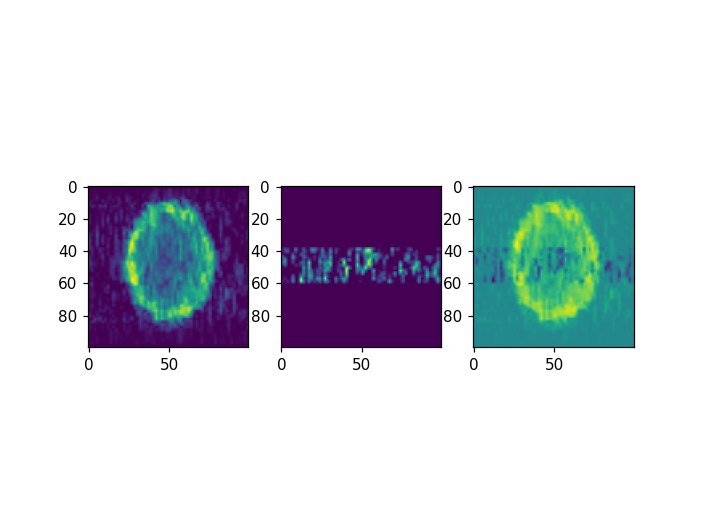

tensor(0)
tensor(1946.3345)


In [27]:
import matplotlib.pyplot as plt

idx = 0
fig, axes = plt.subplots(1,3)
idx = 30
B = next(enumerate(data_loader))[1]
axes[0].imshow(B[0][idx,:].view(100,-1))
axes[1].imshow(train_np[idx,:].reshape(100,-1))
axes[2].imshow(B[0][idx,:].view(100,-1)-train_np[idx,:].reshape(100,-1))
print(B[1][idx])
print(B[0][idx].sum())

<IPython.core.display.Javascript object>


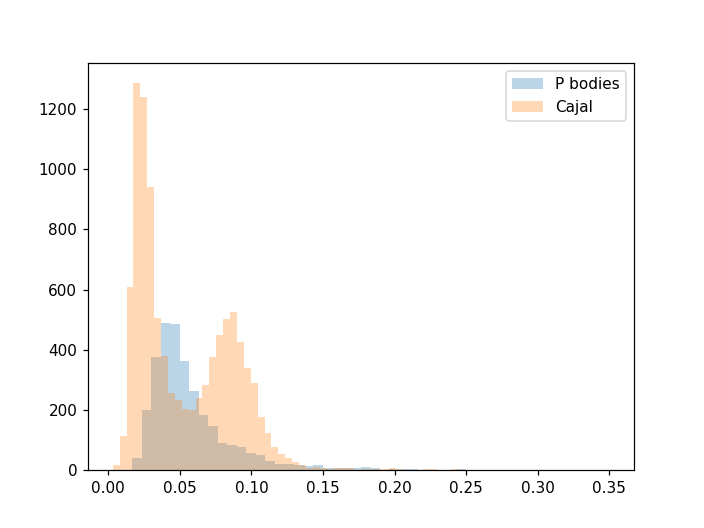

In [48]:
B = next(enumerate(data_loader))[1]
classes = ['cellmask', 'nucleolus', 'centrosome', 'MT', 'cytoplasm', 'ER', 'NE', 'nucleus', 'P bodies', 'Cajal']
id2class = dict(zip(range(10), classes))
ax, fig = plt.subplots(1,1)
for idx, l in enumerate(B[1].unique()[8:10]):
    px_mean = B[0][B[1]==l,:].mean(dim=1)
    plt.hist(px_mean, alpha=0.3, bins=50, label=f"{id2class[l.item()]}")
plt.legend()

# Check nonlinearity

<IPython.core.display.Javascript object>


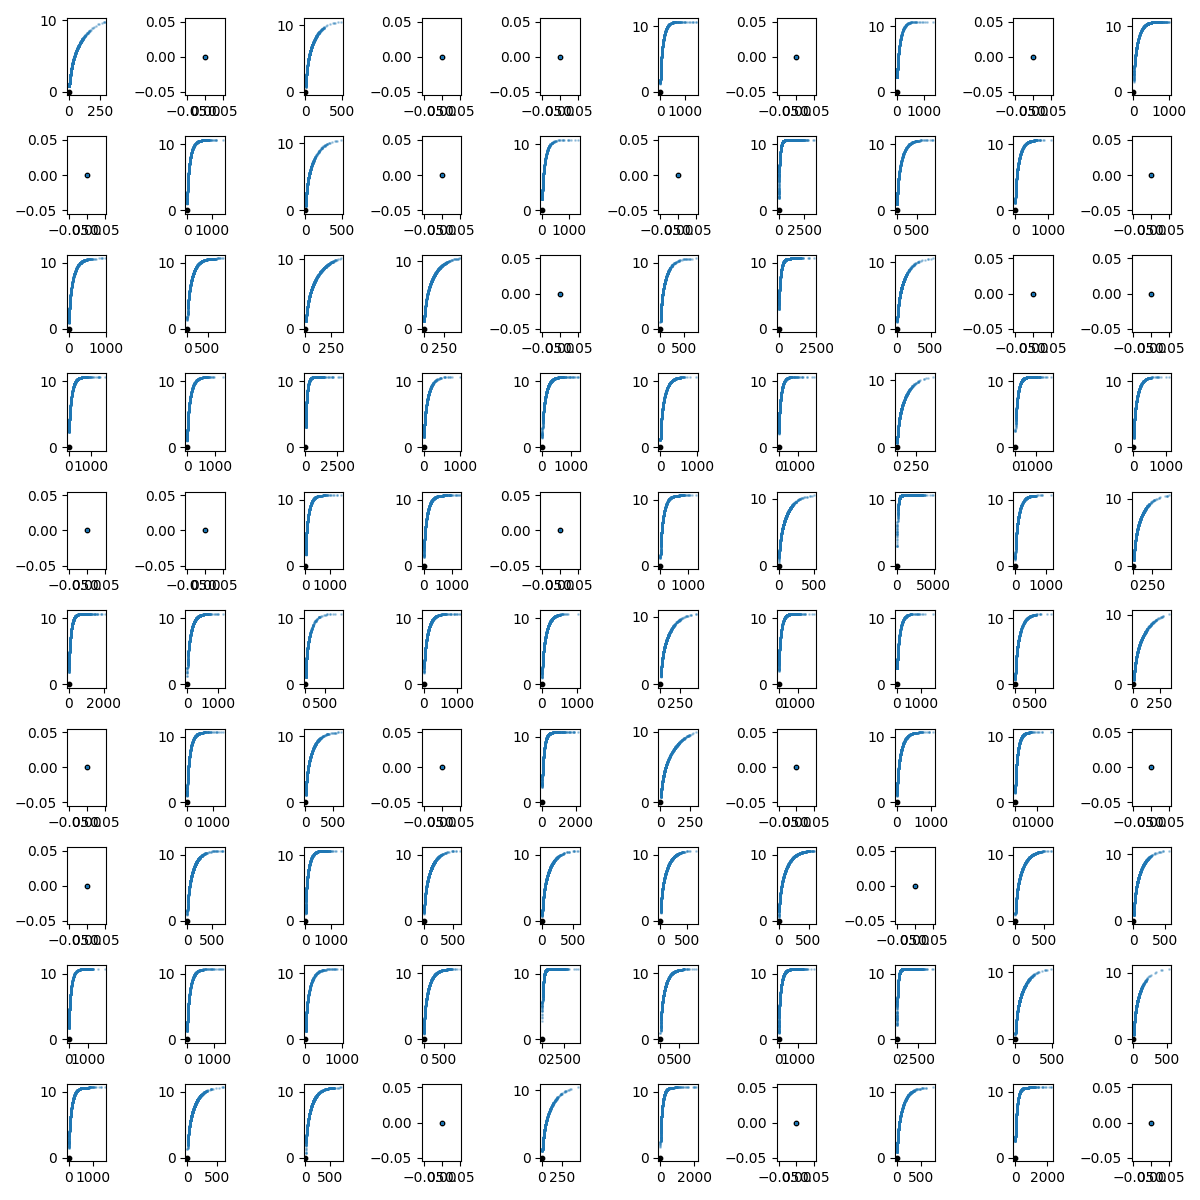

In [131]:
from scipy.optimize import curve_fit

def func2(x, b, c, d, e):
    return (-1.*b*np.exp(-c*x) - d*np.exp(-e*x) + b + d)

coeffs_refit = np.load('./Nonlinearity_Curves_April_8_data_refit.npz')['coeffs']

fig, axes = plt.subplots(10, 10, figsize = (12, 12))
x0 = torch.arange(0, 400/10, 0.1)
# y0s = model.encoder_nn[1](x0.tile(100,1).T)
# p0s = np.ones((36,4))
# p0s[0,:] = [20, 4, 0, 10]
# p0s[3,:] = [10, 1/3, 1, 1]
# p0s[5,:] = [20, 1/3, 1, 1]
# p0s[8,:] = [100, 1/100, 0, 1]
# p0s[12,:] = [10, 1/2, 0, 1]
# p0s[19,:] = [10, 1/2, 0, 1]
# p0s[23,:] = [20, 1/2, 0, 1]
# p0s[33,:] = [10, 1/2, 0, 1]
# p0s[35,:] = [20, 1/2, 0, 1]
# p0s[:,1] = p0s[:,1]/100
# p0s[:,3] = p0s[:,3]/100
# T1_inv = lambda x: (x+7843.875)/2986.897
# T2_inv = lambda x: x/156575.98
# coeffs_new = np.zeros(p0s.shape)
for k in range(100):
    i = k//10
    j = k%10
    ax = axes[i,j]
#     ax.plot(x0, y0s[:,k], 'r')
    ax.scatter(0, 0, s=10, c='k')
    x = hkfc1.output[:,k].detach().numpy()
#     y = model.encoder_nn[1](hkfc1.output[:,k]).detach().numpy()
    y = hkact1.output[:,k].detach().numpy()
    ax.scatter(x, y, s=1, alpha=0.3)
#     ax.set_xlabel('Input Intensity')
#     ax.set_ylabel('Output Intensity')
#     popt, _ = curve_fit(func2, x, y, p0=p0s[k,:], maxfev=5000)
#     print(popt)
#     coeffs_new[k,:] = popt
#     coeffs_new[k,0] = coeffs_new[k,0]*50
#     coeffs_new[k,2] = coeffs_new[k,2]*50
#     ax.plot(x0, func2(x0, *coeffs_new[k,:])/50, 'r--')
#     ax.plot(x0, func2(x0, *coeffs_orig[k,:])/50, 'b')
    

        #ax[i, j].set_xticks([])
        #ax[i, j].set_yticks([])
#plt.savefig('Old_intensifier_nonlinearity', dpi = 1200)
plt.tight_layout()
plt.show()

# Visualize Results

In [15]:
%matplotlib notebook

In [16]:
import matplotlib.pyplot as plt

SMALL_SIZE = 10
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rcParams["font.family"] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## Wide vs narrow NN bar plots

In [29]:
""" Load models """

models = {}

""" Linear classifier """
models['lin'] = OpticalClassifier([100**2, 10])
model_ckpt = torch.load("./Classifier_10_b128_AdamW_lr_0.000334_bs_128_betas_0.9980_0.9995_v_2/ep116.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
models['lin'].load_state_dict(model_state_dict)

""" MLP with 1 hidden layer: 10000-200-10:=10 """
models['H1_narrow'] = OpticalClassifier([100**2, 200, 10])
model_ckpt = torch.load("./Classifier_200_10_b32_AdamW_lr_0.000792_bs_32_betas_0.9998_0.9999_v_16/ep496.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
models['H1_narrow'].load_state_dict(model_state_dict)

""" MLP with 1 hidden layer: 10000-400-40:=10 """
models['H1_wide'] = OpticalClassifier([100**2, 400, 40])
model_ckpt = torch.load("./Classifier_400_40_b64_AdamW_lr_0.001041_bs_64_betas_0.9991_0.9996_v_48/ep484.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
models['H1_wide'].load_state_dict(model_state_dict)

""" MLP with 2 hidden layers: 10000-400-40:=10 """

""" 1 conv layer: cbralsl with 16 channels """
models['conv1_ch16'] = ConvClassifier([100**2, 200, 10], 16)
model_ckpt = torch.load("./Conv1_ch16_200_10_b256_AdamW_lr_0.002076_betas_0.9954_0.9991_swa_80_0.0036_v_69/ep132.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
models['conv1_ch16'].load_state_dict(model_state_dict)

""" 1 conv layer: cbralsl with 64 channels """
models['conv1_ch64'] = ConvClassifier([100**2, 200, 10], 64)
model_ckpt = torch.load("./Conv1_ch64_200_10_b128_AdamW_lr_0.001967_betas_0.9975_0.9998_swa_100_0.0039_v_11/ep102.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
models['conv1_ch64'].load_state_dict(model_state_dict)

""" 3 conv layers: cbrmcbcbr with 16 channels """
models['conv3_ch16'] = ConvClassifier3([100**2, 200, 10], 16)
model_ckpt = torch.load("./cbrmcbrcb_ch16_200_10_b128_AdamW_lr_0.015944_betas_0.9933_0.9994_swa_100_0.0034_v_26/ep200.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
models['conv3_ch16'].load_state_dict(model_state_dict)

""" 3 conv layers: cbrmcbcbr with 64 channels """
models['conv3_ch64'] = ConvClassifier3([100**2, 200, 10], 64)
model_ckpt = torch.load("./cbrmcbrcb_ch64_200_10_b128_AdamW_lr_0.009908_betas_0.9901_0.9994_swa_140_0.0034_v_37/ep141.pt", map_location=torch.device('cpu')) 
model_state_dict = model_ckpt["model_state_dict"]
models['conv3_ch64'].load_state_dict(model_state_dict)


/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


<All keys matched successfully>

In [19]:
import pandas 

B = next(enumerate(test_loader))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]

accus = {}
for k in models.keys():
    model = models[k]
    model.cpu()
    accus[k] = []
    for i in range(10):
        pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
        accuracy = (100. * correct / len(test_labels)).item()
        accus[k].append(accuracy)
df = pandas.DataFrame(accus)
print(df)

         lin  H1_narrow    H1_wide  conv1_ch16  conv1_ch64  conv3_ch16  \
0  70.784943  84.193550  84.473122   90.397850   90.419357   91.935486   
1  70.774193  84.150536  84.344086   90.408600   90.419357   91.956985   
2  70.838707  84.096771  84.387100   90.376343   90.451614   91.924728   
3  70.720428  84.215057  84.215057   90.365593   90.365593   92.032257   
4  70.688171  84.139786  84.537636   90.419357   90.462364   92.010750   
5  70.774193  84.236557  84.354836   90.408600   90.505379   91.892471   
6  70.623657  84.354836  84.376343   90.408600   90.451614   91.967743   
7  70.752686  84.086021  84.290321   90.397850   90.387100   92.000000   
8  70.666664  84.161293  84.247314   90.430107   90.376343   91.967743   
9  70.763443  84.268814  84.354836   90.419357   90.430107   91.989250   

   conv3_ch64  
0   92.698921  
1   92.827957  
2   92.774193  
3   92.655914  
4   92.795700  
5   92.763443  
6   92.741936  
7   92.827957  
8   92.709679  
9   92.752686  


<IPython.core.display.Javascript object>


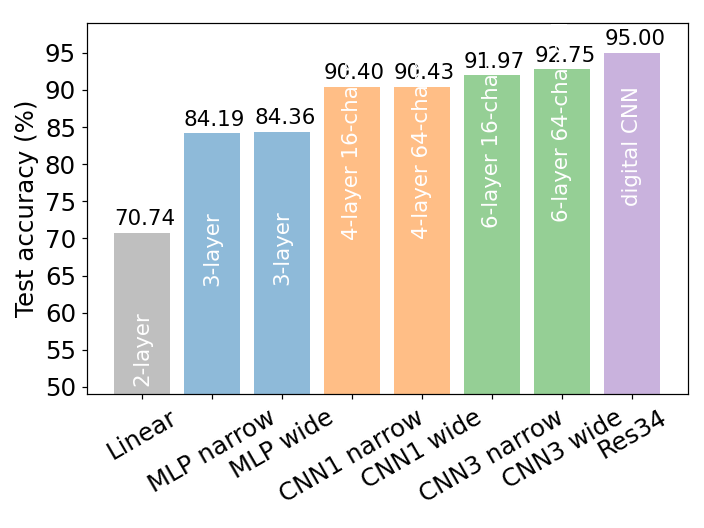

In [26]:
fig, ax = plt.subplots(1,1)

cmap = plt.get_cmap("tab10")
labs = ['Linear', 'MLP narrow', 'MLP wide', 'CNN1 narrow', 'CNN1 wide', 'CNN3 narrow', 'CNN3 wide', 'Res34']
# labs = dict(zip(list(df.columns), labs))
accus = df.mean(axis=0).to_numpy()
accus = np.append(accus, [95.0])
accu_std = df.std(axis=0).to_numpy()
accu_std = np.append(accu_std, [0])
# p1 = ax.bar(labs, accus, yerr=accu_std, color = ['grey', cmap(0), cmap(0), cmap(1), cmap(1), cmap(2), cmap(2), cmap(4)], alpha=0.5, ecolor='black', capsize=10)
p1 = ax.bar(labs, accus, color = ['grey', cmap(0), cmap(0), cmap(1), cmap(1), cmap(2), cmap(2), cmap(4)], alpha=0.5)

# ax.tick_params(axis='x', rotation=45)
# ax.set_xticks(range(6))
ax.tick_params(axis='x', rotation=30)
ax.set_ylim(49, 99)
ax.set_yticks(range(50,96,5))
ax.set_ylabel("Test accuracy (%)")
# ax.bar_label(p1, label_type='edge', padding=5, fontsize=14)
for index, value in enumerate(accus):
    plt.text(index-0.4, value+1, 
             str("{:.2f}".format(value)), fontsize=14)
    
ax.bar_label(p1, ['2-layer', '3-layer', '3-layer', '4-layer 16-channel', '4-layer 64-channel', '6-layer 16-channel', '6-layer 64-channel', 'digital CNN'], \
             color='w', label_type='edge', padding=-100, rotation='vertical', fontsize=14)

fig.tight_layout()
ratio = 1/1.618
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((x_right-x_left)/(y_low-y_high))*ratio)

# ax.bar_label(p2, label_type='edge', padding=5)
# plt.legend()
# plt.savefig('compare_models.svg', dpi = 600, format="svg")

## Accuracy vs bottleneck dimension

In [250]:
""" Load models """

models2 = {}

""" Linear classifiers 10000-X:=10"""
models2['lin'] = {} 
model_dir = {1: "./Classifier_1_b64_AdamW_lr_0.000640_bs_64_betas_0.9935_0.9991_v_88/ep36.pt",\
             2: "./Classifier_2_b128_AdamW_lr_0.000367_bs_128_betas_0.9984_0.9995_v_47/ep150.pt",\
             3: "./Classifier_3_b256_AdamW_lr_0.000411_bs_256_betas_0.9901_0.9991_v_41/ep491.pt",\
             4: "./Classifier_4_b64_AdamW_lr_0.000037_bs_64_betas_0.9959_0.9994_v_28/ep403.pt",\
             6: "./Classifier_6_b64_AdamW_lr_0.000172_bs_64_betas_0.9941_0.9999_v_20/ep283.pt",\
             10: "./Classifier_10_b128_AdamW_lr_0.000334_bs_128_betas_0.9980_0.9995_v_2/ep116.pt",\
             20: "./Classifier_20_b64_AdamW_lr_0.000837_bs_64_betas_0.9914_0.9992_v_99/ep41.pt", \
             50: "./Classifier_50_b64_AdamW_lr_0.000811_bs_64_betas_0.9915_0.9997_v_96/ep70.pt", \
             100: "./Classifier_100_b64_AdamW_lr_0.000235_bs_64_betas_0.9939_0.9992_v_4/ep372.pt", \
             1000: "./Classifier_1000_b64_AdamW_lr_0.000630_bs_64_betas_0.9930_0.9992_v_83/ep86.pt"}
for k in model_dir.keys():
    models2['lin'][k] = OpticalClassifier([100**2, k])
    model_ckpt = torch.load(model_dir[k], map_location=torch.device('cpu')) 
    model_state_dict = model_ckpt["model_state_dict"]
    models2['lin'][k].load_state_dict(model_state_dict)
    
    
""" MLP with 1 hidden layer: 10000-200-X:=10 """
models2['H1'] = {} 
model_dir = {1: "./Classifier_200_1_b128_AdamW_lr_0.008341_bs_128_betas_0.9991_0.9995_swa_300_0.0004_v_114/ep40.pt",\
             2: "./Classifier_200_2_b32_AdamW_lr_0.001245_bs_32_betas_0.9985_0.9996_v_98/ep549.pt",\
             3: "./Classifier_200_3_b32_AdamW_lr_0.001334_bs_32_betas_0.9984_0.9996_v_94/ep498.pt",\
             4: "./Classifier_200_4_b128_AdamW_lr_0.003191_bs_128_betas_0.9999_0.9998_v_72/ep543.pt",\
             6: "./Classifier_200_6_b32_AdamW_lr_0.000738_bs_32_betas_0.9988_0.9994_v_36/ep491.pt",\
             10: "./Classifier_200_10_b32_AdamW_lr_0.000792_bs_32_betas_0.9998_0.9999_v_16/ep496.pt",\
             20: "./Classifier_200_20_b32_AdamW_lr_0.002261_bs_32_betas_0.9993_0.9996_swa_500_0.0004_v_153/ep454.pt", \
             50: "./Classifier_200_50_b32_AdamW_lr_0.000724_bs_32_betas_0.9990_0.9996_v_32/ep496.pt", \
             100: "./Classifier_400_100_b32_AdamW_lr_0.000795_bs_32_betas_0.9946_0.9994_v_124/ep481.pt", \
             1000: "./Classifier_2000_1000_b64_AdamW_lr_0.000661_bs_64_betas_0.9959_0.9997_v_140/ep484.pt"}
for k in model_dir.keys():
    if model_dir[k] != "":
        if k == 100:
            models2['H1'][k] = OpticalClassifier([100**2, 400, k])
        elif k == 1000:
            models2['H1'][k] = OpticalClassifier([100**2, 2000, k])
        else:
            models2['H1'][k] = OpticalClassifier([100**2, 200, k])            
        model_ckpt = torch.load(model_dir[k], map_location=torch.device('cpu')) 
        model_state_dict = model_ckpt["model_state_dict"]
        models2['H1'][k].load_state_dict(model_state_dict)
        
""" 1 conv layer: cbralsl with 16 channels (100x100)-Conv(1,64,7x7,2)-200-X:=10 """
models2['conv1'] = {} 
model_dir = {1: "./Conv1_ch16_200_1_b128_AdamW_lr_0.001239_betas_0.9932_0.9991_swa_80_0.0026_v_68/ep33.pt",\
             2: "./Conv1_ch16_200_2_b128_AdamW_lr_0.001384_betas_0.9992_0.9998_swa_100_0.0022_v_63/ep198.pt",\
             3: "./Conv1_ch16_200_3_b256_AdamW_lr_0.001647_betas_0.9964_0.9998_swa_80_0.0021_v_51/ep249.pt",\
             4: "./Conv1_ch16_200_4_b256_AdamW_lr_0.002206_betas_0.9973_0.9995_swa_60_0.0025_v_42/ep214.pt",\
             6: "./Conv1_ch16_200_6_b256_AdamW_lr_0.002125_betas_0.9971_0.9996_swa_60_0.0019_v_32/ep170.pt",\
             10: "./Conv1_ch16_200_10_b256_AdamW_lr_0.002076_betas_0.9954_0.9991_swa_80_0.0036_v_69/ep132.pt", \
             20: "./Conv1_ch16_200_20_b256_AdamW_lr_0.000542_betas_0.9974_0.9991_swa_60_0.0014_v_35/ep250.pt", \
             50: "./Conv1_ch16_200_50_b256_AdamW_lr_0.000369_betas_0.9972_0.9991_swa_60_0.0038_v_26/ep146.pt", \
             100: "./Conv1_ch16_200_100_b256_AdamW_lr_0.002265_betas_0.9981_0.9997_swa_100_0.0027_v_77/ep101.pt", \
             1000: "./Conv1_ch16_2000_1000_b256_AdamW_lr_0.000078_betas_0.9984_0.9995_swa_60_0.0010_v_15/ep241.pt"}
for k in model_dir.keys():
    if model_dir[k] != "":
        if k == 1000:
            models2['conv1'][k] = ConvClassifier([100**2, 2000, k], 16)
        else:
            models2['conv1'][k] = ConvClassifier([100**2, 200, k], 16)
        model_ckpt = torch.load(model_dir[k], map_location=torch.device('cpu')) 
        model_state_dict = model_ckpt["model_state_dict"]
        models2['conv1'][k].load_state_dict(model_state_dict)
        
""" 3 conv layer: cbralsl with 16 channels (100x100)-Conv(1,64,7x7,2)-Conv(64,64,3x3,2)-Conv(64,64,3x3,2)-200-X:=10 """
models2['conv3'] = {} 
model_dir = {1: "./cbrmcbrcb_ch16_200_1_b128_AdamW_lr_0.008491_betas_0.9942_0.9994_swa_140_0.0027_v_189/ep195.pt",\
             2: "./cbrmcbrcb_ch16_200_2_b256_AdamW_lr_0.012482_betas_0.9903_0.9997_swa_140_0.0015_v_165/ep151.pt",\
             3: "./cbrmcbrcb_ch16_200_3_b128_AdamW_lr_0.010976_betas_0.9910_0.9994_swa_120_0.0027_v_152/ep97.pt",\
             4: "./cbrmcbrcb_ch16_200_4_b128_AdamW_lr_0.009931_betas_0.9904_0.9995_swa_140_0.0031_v_135/ep140.pt",\
             6: "./cbrmcbrcb_ch16_200_6_b128_AdamW_lr_0.013075_betas_0.9913_0.9993_swa_140_0.0031_v_111/ep135.pt",\
             10: "./cbrmcbrcb_ch16_200_10_b128_AdamW_lr_0.015944_betas_0.9933_0.9994_swa_100_0.0034_v_26/ep200.pt", \
             20: "./cbrmcbrcb_ch16_200_20_b128_AdamW_lr_0.011862_betas_0.9924_0.9994_swa_140_0.0035_v_281/ep140.pt", \
             50: "./cbrmcbrcb_ch16_200_50_b128_AdamW_lr_0.026151_betas_0.9903_0.9994_swa_140_0.0033_v_275/ep276.pt", \
             100: "./cbrmcbrcb_ch16_200_100_b128_AdamW_lr_0.010428_betas_0.9974_0.9995_swa_140_0.0033_v_236/ep139.pt", \
             1000: "./refine_cbrmcbrcb_ch16_2000_1000_b128_AdamW_lr_0.000026_betas_0.9901_0.9996_swa_140_0.0031_v_260/ep369.pt"}
for k in model_dir.keys():
    if model_dir[k] != "":
        if k == 1000:
            models2['conv3'][k] = ConvClassifier3([100**2, 2000, k], 16)
        else:
            models2['conv3'][k] = ConvClassifier3([100**2, 200, k], 16)
        model_ckpt = torch.load(model_dir[k], map_location=torch.device('cpu')) 
        model_state_dict = model_ckpt["model_state_dict"]
        models2['conv3'][k].load_state_dict(model_state_dict)
        
        
""" Resnet frontend (100x100)-Conv(1,3,1x1,1)-Res18-512-200-X:=10 """
models2['res18'] = {} 
model_dir = {1: "./retrain_res18_200_1_b128_AdamW_lr_0.000030_betas_0.9913_0.9993_swa_100_0.0028_v_25/ep31.pt",\
             2: "./res18_200_2_b128_AdamW_lr_0.000030_betas_0.9913_0.9993_swa_100_0.0028_v_9/ep31.pt",\
             3: "./retrain_res18_200_3_b128_AdamW_lr_0.000039_betas_0.9912_0.9991_swa_100_0.0016_v_16/ep12.pt",\
             4: "./res18_200_4_b128_AdamW_lr_0.000039_betas_0.9912_0.9991_swa_100_0.0016_v_6/ep12.pt",\
             6: "./res18_200_6_b128_AdamW_lr_0.000030_betas_0.9913_0.9993_swa_100_0.0028_v_19/ep9.pt",\
             10: "./res18_200_10_b128_AdamW_lr_0.000039_betas_0.9912_0.9991_swa_100_0.0016_v_1/ep6.pt", \
             20: "./res18_200_20_b128_AdamW_lr_0.000030_betas_0.9913_0.9993_swa_100_0.0028_v_27/ep6.pt", \
             50: "./res18_200_50_b128_AdamW_lr_0.000039_betas_0.9912_0.9991_swa_100_0.0016_v_20/ep6.pt", \
             100: "./res18_200_100_b128_AdamW_lr_0.000030_betas_0.9913_0.9993_swa_100_0.0028_v_3/ep5.pt", \
             1000: "./res18_2000_1000_b128_AdamW_lr_0.000030_betas_0.9913_0.9993_swa_100_0.0028_v_23/ep4.pt"}
for k in model_dir.keys():
    if model_dir[k] != "":
        if k == 1000:
            models2['res18'][k] = OracleClassifier([100**2, 2000, k])
        else:
            models2['res18'][k] = OracleClassifier([100**2, 200, k])
        model_ckpt = torch.load(model_dir[k], map_location=torch.device('cpu')) 
        model_state_dict = model_ckpt["model_state_dict"]
        models2['res18'][k].load_state_dict(model_state_dict)

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [251]:
import pandas 

B = next(enumerate(test_loader))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]

accus = {}
std = {}
for k1 in models2.keys():
    accus[k1] = {}
    std[k1] = {}
    for k2 in models2[k1].keys():
        model = models2[k1][k2]
        model.cpu()
        accuracy = []
        for i in range(10):
            pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
            accuracy.append((100. * correct / len(test_labels)).item())
        accus[k1][k2] = np.mean(accuracy)
        std[k1][k2] = np.std(accuracy)
            
df2 = pandas.DataFrame.from_dict(accus,orient='index')
df2

KeyboardInterrupt: 

In [254]:
for k2 in [20, 50, 100, 1000]:
    model = models2[k1][k2]
    model.cpu()
    accuracy = []
    for i in range(10):
        pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
        accuracy.append((100. * correct / len(test_labels)).item())
    accus[k1][k2] = np.mean(accuracy)
    std[k1][k2] = np.std(accuracy)
            
df2 = pandas.DataFrame.from_dict(accus,orient='index')
df2

,1,2,3,4,6,10,20,50,100,1000
lin,38.506452,56.880645,67.364516,69.207526,70.665591,70.733332,71.613979,71.701075,72.353763,71.819356
H1,39.398925,66.337634,79.786023,81.868816,83.630106,84.195699,84.241936,84.176344,84.441936,82.608602
conv1,44.847312,77.397850,85.411829,88.127957,90.115055,90.402151,90.546237,90.530107,90.111829,89.672044
conv3,73.576343,88.506452,90.867741,91.818279,92.243010,91.986021,91.753764,91.688171,92.093549,90.638710
res18,79.978493,93.666664,94.688171,94.763443,94.806450,95.182793,95.053764,95.333336,95.268814,94.817207


<IPython.core.display.Javascript object>


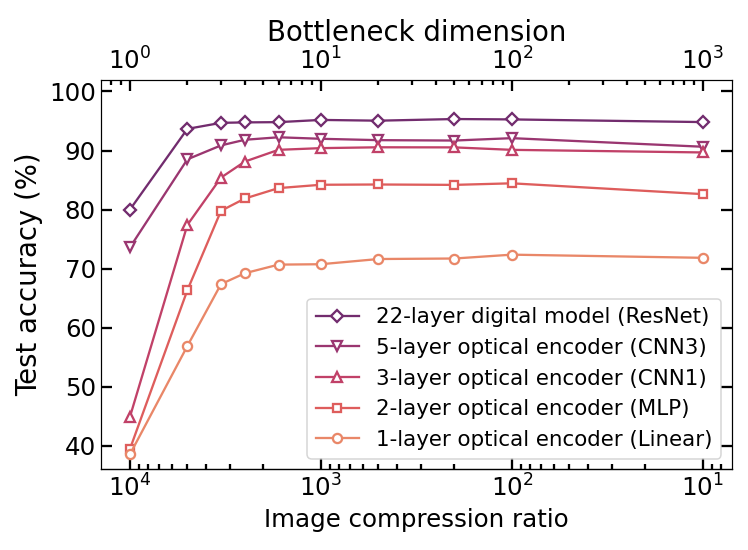

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [292]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(6.8, 5))

pa = sns.color_palette("flare", 5)
df2 = pandas.DataFrame.from_dict(accus,orient='index')
df2 = df2.sort_values(by=[1], ascending=False)

mks = {0: 'D', 1:'v', 2:'^', 3:"s", 4:"o"}
mksizes = {0:6, 1:6, 2:6, 3:5, 4:6}
labs = dict(zip(df2.index, ["22-layer digital model (ResNet)", "5-layer optical encoder (CNN3)", "3-layer optical encoder (CNN1)", "2-layer optical encoder (MLP)", "1-layer optical encoder (Linear)"]))
for i, m in enumerate(df2.index):
    ax.plot(df2.columns, df2.loc[m], marker=mks[i], markerfacecolor="w", markersize=mksizes[i], markeredgewidth=1.5, \
            linewidth=1.5, linestyle='-', color=pa[4-i], label=labs[m])
    
# ax.errorbar(df['nl_correc'].columns[5::10], correc_perc['nl'].mean(axis=0)*100, yerr=correc_perc['nl'].std(axis=0)*100, marker='v', c=cmap(0), capsize=2, label="Nonlinear 2-layer optical encoder")
# # ax.errorbar(df['l_correc'].columns[5::10], correc_perc['l'].mean(axis=0)*100, yerr=correc_perc['l'].std(axis=0)*100, marker='^', c=cmap(3), capsize=2, label="Linear 1-layer optical encoder")
ax.set_ylim(36,102)
# ax.set_xlim(80, 11000)
# ax.set_yticks(list(range(0,101,10)))
# ax.set_xticks([1,2,3,4,6,10,100])

ax.set_xscale('log')
ax.set_ylabel("Test accuracy (%)", fontsize=18)
ax.set_xlabel("Bottleneck dimension", fontsize=18)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top') 
a = 10
ax2 = ax.secondary_xaxis(location = "bottom", functions=(lambda x: a*x, lambda x: a/x))
ax2.set_xlabel("Image compression ratio", fontname="Arial")      
plt.legend(fontsize=14)

ax.tick_params(which="major", length=7, direction="in", width=1.5, right=True)
ax.tick_params(which="minor", length=3, direction="in", width=1.5)
ax2.tick_params(which="major", length=7, direction="in", width=1.5)
ax2.tick_params(which="minor", length=3, direction="in", width=1.5)
# ax2.set_xticks([1,2,3,4,6,10,100])

ratio = 1/1.618
x_left, x_right = ax.get_xlim()
y_low, y_high = ax.get_ylim()
ax.set_aspect(abs((np.log10(x_right)-np.log10(x_left))/(y_low-y_high))*ratio)

plt.tight_layout()
plt.show()
plt.savefig(f"./Figures/accus_vs_nodes_models_v2.svg", dpi=300, format="svg")

## Loss vs compression ratio

In [261]:
import pandas 

B = next(enumerate(test_loader))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]

losses = {}
for k1 in models2.keys():
    losses[k1] = {}
    for k2 in models2[k1].keys():
        model = models2[k1][k2]
        model.cpu()
        loss = []
        for i in range(10):
            outputs = model(test_images).data
            test_loss = nn.CrossEntropyLoss()(outputs, test_labels).item() # sum up batch loss
            loss.append(test_loss)
        losses[k1][k2] = loss

In [272]:
df3 = pandas.DataFrame(index=losses.keys(), columns=losses['lin'].keys())
for k1 in models2.keys():
    for k2 in models2[k1].keys():
        df3.loc[k1,k2] = np.mean(losses[k1][k2]).item()
df3

,1,2,3,4,6,10,20,50,100,1000
lin,1.67954,1.37794,1.2078,1.17244,1.08202,1.06398,1.06757,1.07691,1.14377,1.07704
H1,1.65096,1.14363,0.757041,0.64234,0.563833,0.539478,0.602001,0.599991,0.554225,0.62355
conv1,1.52711,0.878859,0.614589,0.439237,0.356611,0.336684,0.352866,0.369718,0.340711,0.537532
conv3,0.985753,0.470075,0.332338,0.28455,0.257637,0.265734,0.262051,0.273689,0.26629,0.558115
res18,3.83899,1.03625,0.355387,0.340949,0.246399,0.17324,0.169966,0.159487,0.150967,0.167698


<IPython.core.display.Javascript object>


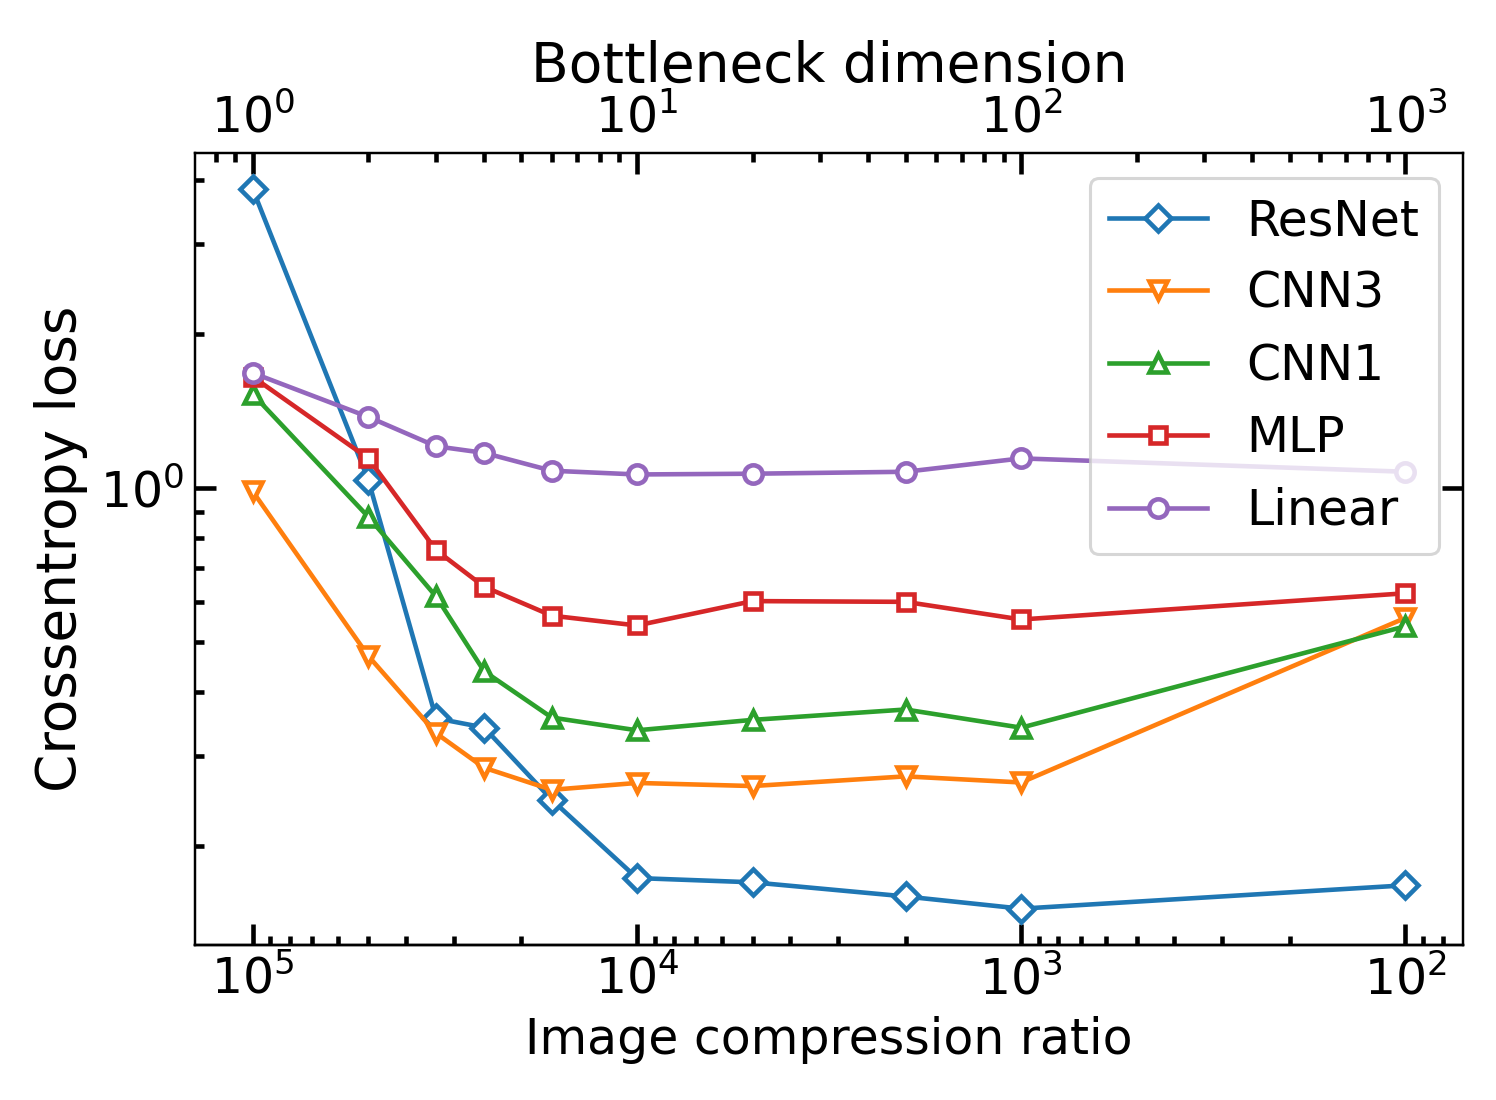

/usr/local/anaconda/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [278]:
import seaborn as sns

fig, ax = plt.subplots(1,1, figsize=(6.8, 5))

pa = sns.color_palette()
df3 = df3.reindex(['lin', 'H1', 'conv1', 'conv3', 'res18'])

mks = {0: 'D', 1:'v', 2:'^', 3:"s", 4:"o"}
mksizes = {0:6, 1:6, 2:6, 3:5, 4:6}
labs = dict(zip(df2.index, ["ResNet", "CNN3", "CNN1", "MLP", "Linear"]))
for i, m in enumerate(df2.index):
    ax.plot(df3.columns, df3.loc[m], marker=mks[i], markerfacecolor="w", markersize=mksizes[i], markeredgewidth=1.5, \
            linewidth=1.5, linestyle='-', color=pa[i], label=labs[m])
    
# ax.errorbar(df['nl_correc'].columns[5::10], correc_perc['nl'].mean(axis=0)*100, yerr=correc_perc['nl'].std(axis=0)*100, marker='v', c=cmap(0), capsize=2, label="Nonlinear 2-layer optical encoder")
# # ax.errorbar(df['l_correc'].columns[5::10], correc_perc['l'].mean(axis=0)*100, yerr=correc_perc['l'].std(axis=0)*100, marker='^', c=cmap(3), capsize=2, label="Linear 1-layer optical encoder")
# ax.set_ylim(36,102)
# ax.set_xlim(80, 11000)
# ax.set_yticks(list(range(0,101,10)))
# ax.set_xticks([1,2,3,4,6,10,100])

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Crossentropy loss", fontsize=18)
ax.set_xlabel("Bottleneck dimension", fontsize=18)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top') 
a = 100
ax2 = ax.secondary_xaxis(location = "bottom", functions=(lambda x: a*x, lambda x: a/x))
ax2.set_xlabel("Image compression ratio", fontname="Arial")      
plt.legend()

ax.tick_params(which="major", length=7, direction="in", width=1.5, right=True)
ax.tick_params(which="minor", length=3, direction="in", width=1.5)
ax2.tick_params(which="major", length=7, direction="in", width=1.5)
ax2.tick_params(which="minor", length=3, direction="in", width=1.5)
# ax2.set_xticks([1,2,3,4,6,10,100])b

# ratio = 1/1.618
# x_left, x_right = ax.get_xlim()
# y_low, y_high = ax.get_ylim()
# ax.set_aspect(abs((np.log10(x_right)-np.log10(x_left))/(y_low-y_high))*ratio)

plt.tight_layout()
plt.show()
# plt.savefig(f"./Figures/losses_vs_nodes_models.svg", dpi=300, format="svg")

In [130]:

model.cpu()
hkconv1 = Hook(model.conv1)
hkfc1 = Hook(model.l1)
hkact1 = Hook(model.a1)
# hkfc3 = Hook(model.encoder_nn[4])
B = next(enumerate(test_loader))[1]
test_images = B[0].to(device="cpu")
test_labels = B[1]
pred = model(test_images).data.max(1, keepdim=True)[1] # get the index of the max log-probability
correct = pred.eq(test_labels.data.view_as(pred)).cpu().sum()
accuracy = 100. * correct / len(test_labels)
print(correct, accuracy)

tensor(899) tensor(89.9000)


In [33]:
print(torch.__version__, optuna.__version__, ray.__version__)

1.11.0+cu102 1.5.0 1.11.0
